# Quantum of drought: evaluating drought anomalies

Welcome back 👋 for the second stage of our journey through drought indicators.   
In the [first notebook](../05-notebook-time-machine/notebook-time-machine.ipynb), we focused on identifying drought events globally using the SPEI index. We explored how this index is calculated and its significance in determining drought conditions across different regions and times.  

Now we want to delve into the process of of quantifying the severity and anomalies of drought events. We will begin by defining drought severity and anomalies, explaining how indices like SPEI contribute to our understanding of these phenomena. The section will clarify the metrics used to measure drought intensity and irregularities in climatic patterns.

## Setting Up the Environment

If you haven't done so already, it's time to install the packages and libraries we'll need: uncomment the lines of code below and run the cells. For more details, please consult the [specific chapter](https://ecmwfcode4earth.github.io/tales-of-drought/chapters/04-set-up-env/set-up-environment.html).

In [1]:
# !pip install numpy 
# !pip install xarray 
# !pip install netCDF4 
# !pip install "dask[complete]"
# !pip install folium
# !pip install matplotlib 
# !pip install plotly
# !pip install -U kaleido
# !pip install ipywidgets
# !pip install pyprojroot

In [2]:
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager  # only for JupyterLab environment

We import the libraries...

In [3]:
import sys
import os
import glob
import xarray as xr
from pyprojroot import here
root = here()
sys.path.append(str(root / "chapters/shared/")) # Add the path to the utils and data directories

In [4]:
from ipywidgets import Layout, Dropdown, widgets
from IPython.display import display, clear_output, IFrame, Markdown
from functools import partial
import datetime
import numpy as np
import utils.widgets_handler as widgets_handler
import utils.coordinates_retrieve as coordinates_retrieve
import utils.data_preprocess as data_preprocess
import utils.charts as charts
import warnings
import plotly.graph_objects as go
warnings.filterwarnings("ignore", category=RuntimeWarning)

... set up the initial state and interface for the interactions...

In [5]:
country_list = widgets_handler.read_json_to_sorted_dict('countries.json')
months = widgets_handler.read_json_to_dict('months.json')
accumulation_windows = widgets_handler.read_json_to_dict('accumulation_windows.json')
subset_area = None
bounding_box = (None, None, None, None)
active_btn = None

selected = {
    "country": None,
    "adm1_subarea": None,
    "adm2_subarea": None,
    "accumulation_window": None,
    "month": None,
    "year": None,
    "year_range": ["2024", "2024"],
    "accumulation_windows_multiple" : ["1 month", "6 months", "12 months"],
    "twenty_years": None
}

placeholders = {
    "country": "no country selected...",
    "adm1_subarea": "no adm1 subarea selected...",
    "adm2_subarea": "no adm2 subarea selected...",
    "accumulation_window": "no accumulation window selected...",
    "month": "no month selected...",
    "year": "no year selected...",
    "year_range": ["2024", "2024"],
    "accumulation_windows_multiple" : ["1 month", "6 months", "12 months"],
    "twenty_years": "no period selected..."
}
widgets_handler.save_selection(placeholders)

..configure the widgets...

In [6]:
# Custom style and layout for descriptions and dropdowns
style = {'description_width': '200px'}
dropdown_layout = Layout(width='400px', display='flex', justify_content='flex-end')
range_layout = Layout(width='400px')
btn_layout = Layout(width='400px')
selectmultiple_layout = Layout(width='400px', display='flex', justify_content='flex-end')

# Dropdown for countries
country_names = [country['name'] for country in country_list]
country_selector = widgets.Dropdown(
    options=[placeholders['country']] + country_names,
    description='Select a country:',
    style=style,
    layout=dropdown_layout
)

# Dropdown for subareas, initially empty
adm1_subarea_selector = widgets.Dropdown(
    options=[placeholders['adm1_subarea']],
    description='a subarea of first level:',
    style=style,
    layout=dropdown_layout
)

adm2_subarea_selector = widgets.Dropdown(
    options=[placeholders['adm2_subarea']],
    description='or of second level:',
    style=style,
    layout=dropdown_layout
)

# Dropdown for accumulation_windows
accumulation_window_selector = widgets.Dropdown(
    options=[placeholders['accumulation_window']] + list(accumulation_windows.keys()),
    description='Select a accumulation window:',
    style=style,
    layout=dropdown_layout
)

# Dropdown for months
month_selector = widgets.Dropdown(
    options=[placeholders['month']] + list(months.keys()),
    description='Select a month:',
    style=style,
    layout=dropdown_layout
)

# Dropdown for years
current_year = datetime.datetime.now().year
years_options = [str(year) for year in range(1940, current_year + 1)]

year_selector = widgets.Dropdown(
    options=[placeholders['year']] + years_options,
    description='Select a year:',
    disabled=False,
    style=style,
    layout=dropdown_layout
)

# SelectionRangeSlider for years
year_range_selector = widgets.SelectionRangeSlider(
    options=years_options,
    index=(len(years_options) - 1, len(years_options) - 1),
    description='Select the year range:',
    disabled=False,
    style=style,
    layout=range_layout
)

# Multiple selector for accumulation windows
accumulation_windows_multiple_selector = widgets.SelectMultiple(
    options=list(accumulation_windows.keys()),
    value=["1 month", "6 months", "12 months"],
    rows=7, 
    description='Accumulation:',
    disabled=False,
    style=style,
    layout=selectmultiple_layout
)


# Dropdown for twenty years
twenty_years_selector = widgets.Dropdown(
    options=[placeholders['twenty_years']] + ["1940-1960", "1960-1980", "1980-2000", "2000-2020", f"1940-{current_year}"],
    description='Select a twenty-year period:',
    disabled=False,
    style=style,
    layout=dropdown_layout
)


selectors = {
    "country" : country_selector,
    "adm1_subarea": adm1_subarea_selector,
    "adm2_subarea": adm2_subarea_selector,
    "accumulation_window": accumulation_window_selector,
    "month": month_selector,
    "year": year_selector,
    "year_range": year_range_selector,
    "accumulation_windows_multiple": accumulation_windows_multiple_selector,
    "twenty_years": twenty_years_selector
}


month_widgets_btn = widgets.Button(
    description='Get data',
    disabled=False,
    button_style='info',
    tooltip='Click me',
    icon='filter',
    layout=btn_layout
)
month_widgets_btn.custom_name='month_widgets_btn'


year_widgets_btn = widgets.Button(
    description='Get data',
    disabled=False,
    button_style='info',
    tooltip='Click me',
    icon='filter',
    layout=btn_layout
)
year_widgets_btn.custom_name='year_widgets_btn'

year_range_widgets_btn = widgets.Button(
    description='Get data',
    disabled=False,
    button_style='info',
    tooltip='Click me',
    icon='filter',
    layout=btn_layout
)
year_range_widgets_btn.custom_name='year_range_widgets_btn'


accumulation_windows_widgets_btn = widgets.Button(
    description='Get data',
    disabled=False,
    button_style='info',
    tooltip='Click me',
    icon='filter',
    layout=btn_layout
)
accumulation_windows_widgets_btn.custom_name='accumulation_windows_widgets_btn'



# Output area for display updates
output_area = widgets.Output()

...and define the functions in the next cell handle the input, process data based on those inputs, and update the notebook interface accordingly:

In [7]:
def setup_observers():
    """
    Sets up observers for UI widgets to handle interactions and updates dynamically in a graphical user interface.
    This function ensures that observers are only set once using a function attribute to track whether observers have
    already been established, enhancing efficiency and preventing multiple bindings to the same event.

    Observer is attached to widgets for country selection. This observer triggers specific functions when the 'value' property 
    of the widgets changes, facilitating responsive updates to the user interface
    based on user interactions.

    Notes:
    - This function uses a custom attribute `observers_set` on itself to ensure observers are set only once.
    """
    if not hasattr(setup_observers, 'observers_set'):      
            # When 'value' changes, update_subareas function will be called to update the dropdown menus
            # Create a partial function that includes the additional parameters
            country_selector.observe(partial(widgets_handler.update_subareas, 
                                         country_list=country_list, 
                                         placeholders=placeholders,
                                         adm1_subarea_selector=adm1_subarea_selector, 
                                         adm2_subarea_selector=adm2_subarea_selector), 'value')
            # Set a flag to indicate observers are set
            setup_observers.observers_set = True


            

def update_and_get_data(btn_name):
    """
    Update and retrieve data based on user interactions and selections.

    This function handles user interactions, validates selections, calculates geographic bounding boxes,
    fetches the corresponding data subset, and updates the output area with relevant information and a map display.
    Additionally, if the button name is 'accumulation_windows_widgets_btn', the function iterates over different
    accumulation windows and fetches data for each, returning a dictionary of the data subsets.
    
    Parameters:
    btn_name (str): The name of the button that triggered the interaction.

    Global Variables:
    selected (dict): Dictionary containing current selections for various parameters.
    placeholders (dict): Dictionary of placeholder values.
    output_area (OutputArea): The output area widget to display messages and results.
    subset_data (xarray.DataArray or dict of xarray.DataArray): Subset of data fetched based on the bounding box.
    index (str): Index for the subset data, constructed from accumulation_window value.
    bounding_box (tuple): Bounding box coordinates (min_lon, min_lat, max_lon, max_lat) for the selected area.
    active_btn (str): The name of the currently active button.

    Steps:
    1. Set the active button name.
    2. Update the month and year selections based on the button interaction.
    3. Validate the current selections.
    4. If selections are valid:
       a. Clear the output area.
       b. Retrieve the geographic boundaries for the selected area.
       c. Calculate the bounding box for the selected area.
       d. Fetch the data subset based on the bounding box.
       e. Determine the administrative level, selected area name, accumulation_window, and time period.
       f. Print information about the uploaded subset data.
       g. Display the map with the bounding box and appropriate zoom level.


    Notes:
    - The function assumes the existence of utility functions within the 'uti' module for handling interactions, validations, 
      data fetching, and map display.
    - The global variables should be properly initialized before calling this function.
    """
    global selected, placeholders, output_area, subset_data, index, bounding_box, active_btn
    map_display = None
    active_btn = btn_name
    widgets_handler.month_year_interaction(btn_name, month_selector, year_selector, selected, placeholders)
    if widgets_handler.validate_selections(btn_name, selected, selectors, placeholders, output_area):
        with output_area:
            output_area.clear_output(wait=True)
            coordinates = coordinates_retrieve.get_boundaries(selected, country_list, placeholders)
            # print(coordinates)
            bounding_box = coordinates_retrieve.calculate_bounding_box(coordinates)
            # print(bounding_box)            
                        
            # sample_coordinates = coordinates[:3] # Showing first 3 coordinates for brevity            
            # print('Original Coordinates Sample: ', sample_coordinates)  
            # print('Bounding Box: ', bounding_box)
                        
            # Fetching data using the bounding box            
            if btn_name == 'accumulation_windows_widgets_btn':
                accumulation_window = ', '.join(selectors['accumulation_windows_multiple'].value)                
                subset_data = {}
                for window in selectors['accumulation_windows_multiple'].value:
                    selectors['accumulation_window'].value = window
                    single_index_data = data_preprocess.get_xarray_data(btn_name, bounding_box, selectors, placeholders, months, accumulation_windows)
                    subset_data[window] = single_index_data
                    print(f"SPEI {window} subset data uploaded, wait...")
            else: 
                subset_data = data_preprocess.get_xarray_data(btn_name, bounding_box, selectors, placeholders, months, accumulation_windows)
                accumulation_window = selected['accumulation_window']
                index = f"SPEI{accumulation_windows[selectors['accumulation_window'].value]}"
            adm_level, selected_area = widgets_handler.get_adm_level_and_area_name(selected, placeholders)
            time_period = widgets_handler.get_period_of_time(btn_name, selected, placeholders)
                
            print(f"SPEI subset data uploaded for {selected_area}, administrative level {adm_level}, accumulation_window {accumulation_window}, period {time_period}")
            zoom_start = 4
            if adm_level == 'ADM1' or adm_level == 'ADM2':
                zoom_start = 8  
            map_display = coordinates_retrieve.display_map(bounding_box, zoom_start)
            map_iframe = coordinates_retrieve.display_map_in_iframe(map_display)
            display(map_iframe)

            
# Set up widget interaction
def on_button_clicked(btn):
    update_and_get_data(btn.custom_name)

# Setup observers
setup_observers()

## Data selection

It's time for your second analysis: selected the geographic area you are interested in, the accumulation window of the SPEI index and the referring year.  
Regarding the choice of the area, please take into account that the larger the area, the more computational power and time it will take to retrieve the data. So, if your device is not powerful, choose smaller areas, such as second-level subareas.

If you click the 'Get data' button before choosing the necessary options from the dropdown menu, a message will be displayed under the widgets' block explaining what you missed. 

If all the selections are made, you will receive three messages:
1. The retrieval of the coordinates for the selected area was successful ('Coordinates retrieved for...').
2. The data retrieval was successful ('SPEI subset data uploaded for...')
3. A map of the selected area is displayed, which can help you check if the area is the one you are interested in.

In [8]:
# # Update existing selectors
# previous_selection = widgets_handler.read_json_to_dict('selection.json')

# # Set up widgets with previous settings
# country_selector.value = previous_selection.get('country', placeholders['country'])
# adm1_subarea_selector.value = previous_selection.get('adm1_subarea', placeholders['adm1_subarea'])
# adm2_subarea_selector.value = previous_selection.get('adm2_subarea', placeholders['adm2_subarea'])
# accumulation_window_selector.value = previous_selection.get('accumulation_window', placeholders['accumulation_window'])
# year_selector.value = previous_selection.get('year', placeholders['year'])
# year_widgets_btn.on_click(on_button_clicked)

# # Display widgets
# display(country_selector, adm1_subarea_selector, adm2_subarea_selector, accumulation_window_selector, year_selector, year_widgets_btn, output_area)

In [9]:
# # Update existing selectors
# previous_selection = widgets_handler.read_json_to_dict('selection.json')

# # Set up widgets with previous settings
# country_selector.value = previous_selection.get('country', placeholders['country'])
# adm1_subarea_selector.value = previous_selection.get('adm1_subarea', placeholders['adm1_subarea'])
# adm2_subarea_selector.value = previous_selection.get('adm2_subarea', placeholders['adm2_subarea'])
# accumulation_window_selector.value = previous_selection.get('accumulation_window', placeholders['accumulation_window'])
# year_range_selector.value = previous_selection.get('year_range')
# year_range_widgets_btn.on_click(on_button_clicked)

# # Display widgets
# display(country_selector, adm1_subarea_selector, adm2_subarea_selector, accumulation_window_selector, year_range_selector, year_range_widgets_btn, output_area)

Now you have retrieved the data of your interest in a variable named `subset_data[index]`, where index is the SPEI index you have chosen.

Using the `data_preprocess.display_data_details` function, you can examine your data to check the following:
- If the values chosen from the dropdown menu are correct.
- The number of time, latitude, and longitude values present.
- A sample of the first SPEI values.

In [10]:
# data_preprocess.display_data_details(active_btn, selected, subset_data[index])

In [11]:
# processed_subset, change_summary = data_preprocess.process_datarray(subset_data[index])
# print(processed_subset, '\n')
# print('Change summary:')
# for key, val in change_summary.items():
#     print(key, val)

In [12]:
# # get drought data
# drought_subset = processed_subset.sel(time=slice("2008-01-01", "2010-12-31"))
# print(drought_subset)

In [17]:
def get_spi_dataset(acc_period: str = 1, years: list = [2020]):
    data_root_folder = '/data1/drought_dataset/spi/'
    spi_folder = os.path.join(data_root_folder, f'spi{acc_period}')
    spi_paths = []

    for year in years:
        spi_paths.extend(sorted(glob.glob(
            f'{data_root_folder}spi{acc_period}/SPI{acc_period}_gamma_global_era5_moda_ref1991to2020_{year}*.nc')))

    return xr.open_mfdataset(spi_paths, chunks={'time': "auto"}, concat_dim="time", combine='nested', parallel=False)


def get_spei_dataset(acc_period: str = 1, years: list = [2020]):
    data_root_folder = '/data1/drought_dataset/spei/'
    spi_folder = os.path.join(data_root_folder, f'spi{acc_period}')
    spi_paths = []

    for year in years:
        spi_paths.extend(sorted(glob.glob(
            f'{data_root_folder}spei{acc_period}/SPEI{acc_period}_genlogistic_global_era5_moda_ref1991to2020_{year}*.nc')))

    return xr.open_mfdataset(spi_paths, chunks={'time': "auto"}, concat_dim="time", combine='nested', parallel=False)


def mask_invalid_values(ds, variable, value=-9999):
    ds[variable] = ds[variable].where(ds[variable] != value, np.nan)
    return ds


def subset_region(dataset, variable, bbox):
    # data = dataset.sel(time=np.datetime64(time), method='nearest')[variable]

    # Define the geographical boundaries for Madagascar
    lat_bounds = [bbox[1], bbox[3]]  # from south to north
    lon_bounds = [bbox[0], bbox[2]]  # from west to east

    # Check for NaN values in latitude and longitude coordinates
    lat_nan = dataset['lat'].isnull().any()
    lon_nan = dataset['lon'].isnull().any()

    # Handle NaN values if they exist
    if lat_nan:
        dataset = dataset.dropna(dim='lat', how='all')
    if lon_nan:
        dataset = dataset.dropna(dim='lon', how='all')

    # Ensure no NaN values in the data itself
    dataset = dataset.fillna(np.nan)  # or use another appropriate method like interpolation

    # Ensure the lat/lon bounds are within the data's range
    lat_min, lat_max = dataset['lat'].min().item(), dataset['lat'].max().item()
    lon_min, lon_max = dataset['lon'].min().item(), dataset['lon'].max().item()

    if lat_bounds[0] < lat_min or lat_bounds[1] > lat_max or lon_bounds[0] < lon_min or lon_bounds[1] > lon_max:
        raise ValueError("The specified latitude/longitude bounds are outside the range of the dataset.")

    # Subset the data using where and dropna
    dataset = dataset.where(
        (dataset['lat'] >= lat_bounds[0]) & (dataset['lat'] <= lat_bounds[1]) &
        (dataset['lon'] >= lon_bounds[0]) & (dataset['lon'] <= lon_bounds[1]),
        drop=True
    )

    # return xr.Dataset(data)
    return dataset
    
def get_spei_significance_dataset(variable='SPEI1', year=2020):
    data_root_folder='/data1/drought_dataset/spei/'
    quality_paths = []
    for month in range(1, 13):
        month_str = f'{month:02d}'
        quality_paths.append(f'{data_root_folder}{variable.lower()}/parameter/{variable}_significance_global_era5_moda_{year}{month_str}_ref1991to2020.nc')
    return xr.open_mfdataset(quality_paths, concat_dim="time", combine='nested', parallel=False)

def get_spi_significance_dataset(variable='SPI1', year=2020):
    data_root_folder='/data1/drought_dataset/spi/'
    quality_paths = []
    for month in range(1, 13):
        month_str = f'{month:02d}'
        quality_paths.append(f'{data_root_folder}{variable.lower()}/parameter/{variable}_significance_global_era5_moda_{year}{month_str}_ref1991to2020.nc')
    return xr.open_mfdataset(quality_paths, concat_dim="time", combine='nested', parallel=False)

In [18]:
bbox = [33.9118194576019505, -4.7022705079775156, 41.9062576293861184, 5.4306483270586909]
# spi1 = get_spi_dataset(acc_period=1, years=[2020])
# spi12 = get_spi_dataset(acc_period=12, years=[2020])
# # spei1 = get_spei_dataset(acc_period=1, years=[2020])
spei12 = get_spei_dataset(acc_period=12, years=[2020])

# spi1_full = get_spi_dataset(acc_period=1, years=list(range(1940, 2023)))
# spi48_full = get_spi_dataset(acc_period=48, years=list(range(1940, 2023)))
# spei1_full = get_spei_dataset(acc_period=1, years=list(range(1940, 2023)))
spei48_full = get_spei_dataset(acc_period=48, years=list(range(1940, 2023)))

# spi1_region = mask_invalid_values(subset_region(spi1, variable='SPI1', bbox=bbox), variable='SPI1')
# spi12_region = mask_invalid_values(subset_region(spi12, variable='SPI12', bbox=bbox), variable='SPI12')
# spei1_region = mask_invalid_values(subset_region(spei1, variable='SPEI1', bbox=bbox), variable='SPEI1')
# spei12_region = mask_invalid_values(subset_region(spei12, variable='SPEI12', bbox=bbox), variable='SPEI12')

# spi1_region_full = mask_invalid_values(subset_region(spi1_full, variable='SPI1', bbox=bbox), variable='SPI1')
# spi12_region_full = mask_invalid_values(subset_region(spi12_full, variable='SPI12', bbox=bbox), variable='SPI12')
# spei1_region_full = mask_invalid_values(subset_region(spei1_full, variable='SPEI1', bbox=bbox), variable='SPEI1')
spei48_region_full = mask_invalid_values(subset_region(spei48_full, variable='SPEI48', bbox=bbox), variable='SPEI48')

# spei1_significance = get_spei_significance_dataset(year=2020)
# spi1_significance = get_spi_significance_dataset(year=2020)

# spei1_significance_region = mask_invalid_values(subset_region(spei1_significance, variable='significance', bbox=bbox), variable='significance', value=0.)
# spi1_significance_region = mask_invalid_values(subset_region(spi1_significance, variable='significance', bbox=bbox), variable='significance', value=0.)

In [27]:
processed_subset = spei48_region_full['SPEI48']

It’s possible that the subset of data you select may contain missing or invalid entries. This could be due to factors like the data being from distant years, a malfunctioning remote sensor, or simply because the data point is over a sea. For instance, a value like -9999 is not acceptable. Additionally, some date formats might differ, causing further discrepancies. 

The following function is designed to tackle these issues and returns:
- the `processed_subset`, which is the cleaned and corrected version of your data.
- the `change_summary`, detailing the corrections applied to the original subset.

Now we have the data for this specific drought, we want to examime certain criteria of the drought, such as the severity, intensity, duration, spatial extent.  If we determine a drought threshold to be an SPEI < -1.5, we can determine the percentage of the data which falls below this threshold, for this specific event and also for historical data.

In [29]:
import dask.array as da
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import label
import numpy as np

# Load your dataset (replace 'your_dataset.nc' with your actual data file)
# For example, assuming your data is in a NetCDF format:


# Suppose 'spei' is the variable name and 'time' is the time coordinate in your dataset
spei = processed_subset

# Define threshold and minimum gap period
threshold = -1.5
min_gap_period = 2  # Minimum number of months SPEI must stay above threshold to end a drought event

# Identify where SPEI is below the threshold
drought_mask = spei < threshold

# Compute the difference along the time dimension to identify transitions
# drought_events = drought_mask.astype(int).diff(dim='time', label='upper')

# Label drought events by cumulatively summing the transitions
# Function to label drought events along the time axis
def label_drought_events(mask, structure=None):
    labeled_array, num_features = label(mask, structure=structure)
    return labeled_array

# Apply the labeling function along the time dimension for each (latitude, longitude) pair
drought_labels = xr.apply_ufunc(
    label_drought_events,
    drought_mask.chunk(dict(time=-1)),
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[np.int32]
)

# Calculate the duration of each drought event by grouping by label and counting along the time dimension
event_lengths = drought_labels.groupby(drought_labels).count(dim='time').compute()

# Filter out short non-drought periods by checking for the minimum gap period
valid_drought_events = event_lengths.where(event_lengths > min_gap_period, drop=True)

# Extract the start and end times of each drought event
start_end_times = drought_labels.where(drought_labels != 0).to_dataframe().reset_index()



In [30]:
start_end_times

,lat,lon,time,SPEI48
0,5.25,34.00,1940-01-01 06:00:00,NaN
1,5.25,34.00,1940-02-01 06:00:00,NaN
2,5.25,34.00,1940-03-01 06:00:00,NaN
3,5.25,34.00,1940-04-01 06:00:00,NaN
4,5.25,34.00,1940-05-01 06:00:00,NaN
...,...,...,...,...
1274875,-4.50,41.75,2022-08-01 06:00:00,NaN
1274876,-4.50,41.75,2022-09-01 06:00:00,NaN
1274877,-4.50,41.75,2022-10-01 06:00:00,NaN
1274878,-4.50,41.75,2022-11-01 06:00:00,NaN


                                 start                 end   duration
lat   lon   SPEI48                                                   
-4.50 34.00 1.0    1944-03-01 06:00:00 1947-05-01 06:00:00  38.533333
            2.0    1947-08-01 06:00:00 1947-09-01 06:00:00   1.033333
            3.0    1997-03-01 06:00:00 1997-03-01 06:00:00   0.000000
            4.0    2005-11-01 06:00:00 2007-01-01 06:00:00  14.200000
            5.0    2007-05-01 06:00:00 2007-05-01 06:00:00   0.000000
...                                ...                 ...        ...
 5.25 41.75 4.0    2010-12-01 06:00:00 2010-12-01 06:00:00   0.000000
            5.0    2011-03-01 06:00:00 2012-01-01 06:00:00  10.200000
            6.0    2012-03-01 06:00:00 2013-02-01 06:00:00  11.233333
            7.0    2014-04-01 06:00:00 2014-09-01 06:00:00   5.100000
            8.0    2022-05-01 06:00:00 2022-12-01 06:00:00   7.133333

[7177 rows x 3 columns]


InvalidIndexError: (array(1.5), array(37.75))

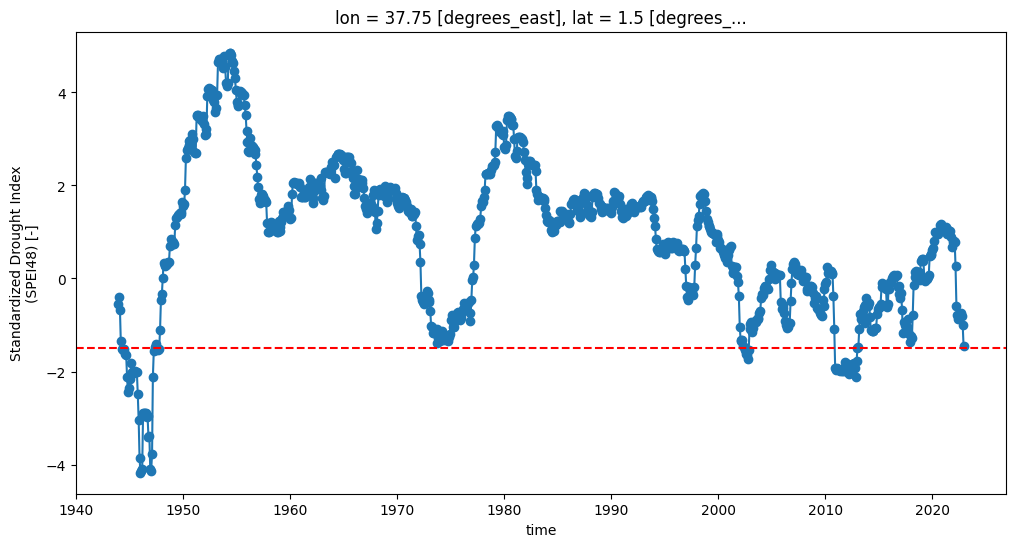

In [31]:
# Group by event labels to get start and end times for each event across all spatial points
event_groups = start_end_times.groupby(['lat', 'lon', 'SPEI48'])

# Extract start and end times for each labeled drought event across the spatial dimensions
drought_periods = event_groups.apply(lambda x: pd.Series({
    'start': x['time'].min(),
    'end': x['time'].max(),
    'duration': (x['time'].max() - x['time'].min()).days/30
}),include_groups=False)

# Print the drought events summary
print(drought_periods)

# Visualize a specific grid point for illustration (adjust the latitude and longitude indices as needed)
lat_index = 15  # Example index for latitude
lon_index = 15  # Example index for longitude

# Extract the time series for the selected grid point
spei_point = spei.isel(lat=lat_index, lon=lon_index).compute()

plt.figure(figsize=(12, 6))
spei_point.plot(label='SPEI', marker='o')

plt.axhline(y=threshold, color='r', linestyle='--', label=f'Drought Threshold (SPEI={threshold})')

# Visualize the drought periods at the selected grid point
for i, row in drought_periods.loc[(spei.lat[lat_index].values, spei.lon[lon_index].values)].iterrows():
    plt.axvspan(row['start'], row['end'], color='red', alpha=0.2)

plt.title(f'SPEI Time Series with Drought Events at lat={ds.lat.values[lat_index]}, lon={ds.lon.values[lon_index]}')
plt.xlabel('Time')
plt.ylabel('SPEI')
plt.legend()
plt.show()

In [32]:
drought_periods

start                 end   duration
lat   lon   SPEI48                                                   
-4.50 34.00 1.0    1944-03-01 06:00:00 1947-05-01 06:00:00  38.533333
            2.0    1947-08-01 06:00:00 1947-09-01 06:00:00   1.033333
            3.0    1997-03-01 06:00:00 1997-03-01 06:00:00   0.000000
            4.0    2005-11-01 06:00:00 2007-01-01 06:00:00  14.200000
            5.0    2007-05-01 06:00:00 2007-05-01 06:00:00   0.000000
...                                ...                 ...        ...
 5.25 41.75 4.0    2010-12-01 06:00:00 2010-12-01 06:00:00   0.000000
            5.0    2011-03-01 06:00:00 2012-01-01 06:00:00  10.200000
            6.0    2012-03-01 06:00:00 2013-02-01 06:00:00  11.233333
            7.0    2014-04-01 06:00:00 2014-09-01 06:00:00   5.100000
            8.0    2022-05-01 06:00:00 2022-12-01 06:00:00   7.133333

[7177 rows x 3 columns]

In [33]:
spei = processed_subset


# Define the threshold for drought and the minimum gap between events
drought_threshold = -1.5
min_gap_months = 4
min_area_coverage = 0.25  # e.g., 50% of grid points must be below the threshold

# Identify where SPEI is below the threshold (i.e., drought condition) across all grid points
drought_mask = spei < drought_threshold

# # Determine if at least one grid point is in drought at each time step
# global_drought_mask = drought_mask.any(dim=['lat', 'lon'])

# Calculate the proportion of grid points below the threshold at each time step
drought_proportion = drought_mask.mean(dim=['lat', 'lon'])

# Determine if the proportion of grid points in drought exceeds the area coverage threshold at each time step
global_drought_mask = drought_proportion >= min_area_coverage

# Label global drought events along the time dimension
drought_labels, num_events = label(global_drought_mask)

# Initialize lists to store event start and end times
event_starts = []
event_ends = []

# Extract start and end times for each drought event
for i in range(1, num_events + 1):
    event_mask = drought_labels == i
    if event_mask.any():
        start_time = spei.time.where(event_mask).min(skipna=True).values
        end_time = spei.time.where(event_mask).max(skipna=True).values
        event_starts.append(start_time)
        event_ends.append(end_time)

# Create a DataFrame with the drought events
drought_events = pd.DataFrame({
    'start': pd.to_datetime(event_starts),
    'end': pd.to_datetime(event_ends)
})
drought_events['duration_months'] = ((drought_events['end'] - drought_events['start']).dt.days / 30).astype(int)

# Find gaps between drought events
drought_events = drought_events.sort_values('start')
drought_events['next_start'] = drought_events['start'].shift(-1)
drought_events.next_start.iat[-1] = drought_events.start.iat[-1]
drought_events['gap_months'] = ((drought_events['next_start'] - drought_events['end']).dt.days / 30).astype(int)

# Filter events to ensure they are separated by at least the minimum gap
merged_events = []
current_event = drought_events.iloc[0]

for idx, row in drought_events.iterrows():
    if row['start'] <= current_event['end'] + pd.DateOffset(months=min_gap_months):
        # Extend the current event
        current_event['end'] = max(current_event['end'], row['end'])
    else:
        # Finalize the current event and start a new one
        merged_events.append(current_event)
        current_event = row

# Add the last event
merged_events.append(current_event)

# Create a DataFrame for merged events
merged_drought_events = pd.DataFrame(merged_events)

# Calculate the duration of each merged drought event in months
merged_drought_events['duration_months'] = ((merged_drought_events['end'] - merged_drought_events['start']).dt.days / 30).astype(int)


# Print the valid drought events summary
print(merged_drought_events)

# Visualization of SPEI time series with drought events
# plt.figure(figsize=(12, 6))

# # Plot the global drought mask to show when drought occurred
# global_drought_mask.plot(label='Drought Occurrence', marker='o')

# for i, row in merged_drought_events.iterrows():
#     plt.axvspan(row['start'], row['end'], color='red', alpha=0.2, label=f'Drought Event {i+1}')

# plt.title('Drought Events with Duration and Minimum Gap Requirement')
# plt.xlabel('Time')
# plt.ylabel('Drought Occurrence (1 = Drought, 0 = No Drought)')
# plt.legend()
# plt.show()


                start                 end  duration_months  \
0 1943-12-01 06:00:00 1947-11-01 06:00:00               47   
1 2002-02-01 06:00:00 2002-11-01 06:00:00                9   
3 2006-01-01 06:00:00 2006-04-01 06:00:00                3   
5 2011-01-01 06:00:00 2011-10-01 06:00:00                9   
6 2012-03-01 06:00:00 2013-02-01 06:00:00               11   
7 2017-12-01 06:00:00 2018-02-01 06:00:00                2   

           next_start  gap_months  
0 2002-02-01 06:00:00         660  
1 2002-05-01 06:00:00           2  
3 2006-04-01 06:00:00           3  
5 2012-03-01 06:00:00           5  
6 2017-12-01 06:00:00          58  
7 2017-12-01 06:00:00          -2  


/tmp/ipykernel_1902074/301597768.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_event['end'] = max(current_event['end'], row['end'])


In [34]:
merged_drought_events

,start,end,duration_months,next_start,gap_months
0,1943-12-01 06:00:00,1947-11-01 06:00:00,47,2002-02-01 06:00:00,660
1,2002-02-01 06:00:00,2002-11-01 06:00:00,9,2002-05-01 06:00:00,2
3,2006-01-01 06:00:00,2006-04-01 06:00:00,3,2006-04-01 06:00:00,3
5,2011-01-01 06:00:00,2011-10-01 06:00:00,9,2012-03-01 06:00:00,5
6,2012-03-01 06:00:00,2013-02-01 06:00:00,11,2017-12-01 06:00:00,58
7,2017-12-01 06:00:00,2018-02-01 06:00:00,2,2017-12-01 06:00:00,-2


Now we have identified the drought events which took place in the selected area and timeframe, we can determine the area affected and intensity of each drought event.  We will determine the area affected by calculating the % of points within the area of the drought event with an SPEI < -1.5, and calculate an average of the area affected.

In [35]:
def get_percentage_pts_below_threshold(data):
    
    # calculate the total number of points in dataset
    total_points =data.size

    # define mask to data subset where SPEI < -1.5
    drought_mask = data < threshold

    # calculate the number of points below the threshold
    points_below_threshold = drought_mask.sum().values

    # calculate the percentage of points below the threshold
    percentage_below_threshold = (points_below_threshold / total_points) * 100

    return percentage_below_threshold

39.19259982638889


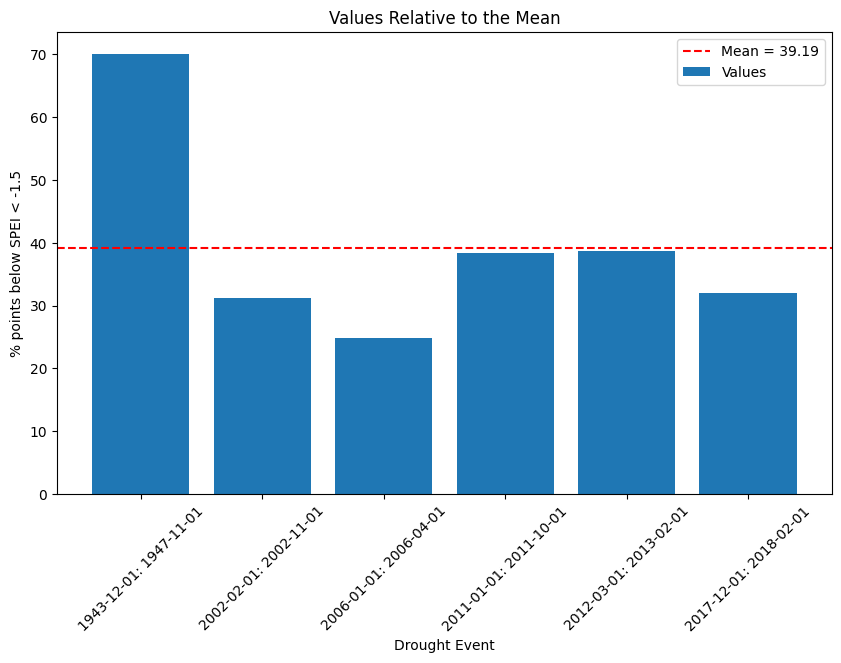

In [38]:
drought_event_percs = []
drought_event_dates = []

# loop through the drought events
for index, row in merged_drought_events.iterrows():
    # Extract start and end dates
    start_date = row['start']
    end_date = row['end']

    drought_event_dates.append(f"{start_date.date()}: {end_date.date()}")

    # get dataset for the event
    drought_event_data = processed_subset.sel(time=slice(start_date, end_date))

    # calc % area affected
    drought_area_perc = get_percentage_pts_below_threshold(drought_event_data)

    drought_event_percs.append(drought_area_perc)
    
    # Process the dates (for example, print them)
    #print(f"Row {index}: Start Date = {start_date}, End Date = {end_date}")

average_area_perc = sum(drought_event_percs) / len(drought_event_percs)

# Plotting
plt.figure(figsize=(10, 6))

# Plot the values as bars
plt.bar(drought_event_dates, drought_event_percs, label='Values')

# Add a horizontal line for the mean
plt.axhline(y=average_area_perc, color='r', linestyle='--', label=f'Mean = {average_area_perc:.2f}')

# Add labels and title
plt.xlabel('Drought Event')
plt.xticks(rotation=45)
plt.ylabel('% points below SPEI < -1.5')
plt.title('Values Relative to the Mean')
plt.legend()

# Show the plot
plt.show()

In [40]:
## DELETE

# define drought threshold
# drought_threshold = -1.5

# # % data below threshold for chosen subset
# #print(get_percentage_pts_below_threshold(drought_subset))

# start_year = 1940
# end_year = 2020

# # Generate a list of years from start_year to end_year
# years = list(range(start_year, end_year))

# years_percentages = []
# years_labels = []

# # data below threshold for another dataset/total dataset (?) eg:
# for year in years:
#     time_slice = slice(f"{year}-01-01", f"{year}-12-31")
#     data = processed_subset.sel(time=time_slice)
#     data_perc = get_percentage_pts_below_threshold(data)
#     # print(f"{year}: {data_perc}")
#     years_percentages.append(data_perc)
#     years_labels.append(year)

# # data for plotting
# p
# rint(years)
# print(years_percentages)




NameError: name 'p' is not defined

In [39]:
# fig = go.Figure()
# fig.add_trace(go.Bar(x=list(years_labels), y=years_percentages))
# fig.update_layout(title = {'text':'Spatial extend of drought events', 
#                            'y':0.9,
#                            'x':0.5,
#                            'xanchor': 'center',
#                            'yanchor': 'top'})
# fig.update_xaxes(title_text="Years")
# fig.update_yaxes(title_text='Area % classified as drought')
# fig.show()

NameError: name 'years_labels' is not defined

In [ ]:
copy_dataset = processed_subset.copy()

In [ ]:
durations = (copy_dataset<-1.5).any(dim=['lat','lon']).astype(int)

In [ ]:
durations

In [ ]:
import pandas as pd
months = pd.to_datetime(durations.time)

In [ ]:
values = durations.values

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(months), y=values))
# fig.update_layout(title = {'text':'Spatial extend of drought events', 
#                            'y':0.9,
#                            'x':0.5,
#                            'xanchor': 'center',
#                            'yanchor': 'top'})
fig.update_xaxes(title_text="Years",dtick="M1", tickformat="%b\n%Y")
fig.update_yaxes(title_text='Area % classified as drought')
fig.show()

In [ ]:
import xarray as xr
import numpy as np
import dask.array as da

# Define drought events by spei < threshold and at least min_coverage % area coverage. 
# For those calculate the duration of them. 
# Result is a list of values. Its length is the number of drought events in the area and each value is the duration in months


# Assuming 'spei' is a 3D DataArray with dimensions ['time', 'lat', 'lon']
# Example: spei = xr.DataArray(...)

# Define the drought threshold (e.g., -1.5 for severe drought)
threshold = -1.5
spei = copy_dataset

# Create a boolean mask for drought events (True if below the threshold)
drought_mask = spei < threshold

# Calculate the percentage of grid points in drought at each time step
percentage_below_threshold = drought_mask.mean(dim=['lat', 'lon']) * 100

# Define the minimum area coverage for a drought (e.g., 50%)
min_coverage = 50

# Identify time steps where drought covers at least 50% of the area
drought_condition = percentage_below_threshold >= min_coverage

# Convert the boolean condition to a NumPy array for easier manipulation
drought_condition_np = drought_condition.compute().values

# Calculate the duration of each drought event
drought_durations = []
current_duration = 0

for is_drought in drought_condition_np:
    if is_drought:
        current_duration += 1
    else:
        if current_duration > 0:
            drought_durations.append(current_duration)
            current_duration = 0

# Append the last drought duration if the series ended with a drought
if current_duration > 0:
    drought_durations.append(current_duration)

print("Drought durations (in time steps):", drought_durations)


Next we can look at the number of drought events that have occurred at this location over the time period we are examining.  

In [ ]:
def get_number_of_drought_events(data):
    # define mask to data subset where SPEI < -1.5
    drought_mask = data < drought_threshold
    
    # apply mask to get drought events
    drought_events = processed_subset.where(drought_mask)
    
    # count num of drought events
    drought_count = drought_mask.sum(dim=['lat', 'lon'])
    
    # count drought events by month and year
    monthly_drought_count = drought_count.resample(time='ME').sum()
    yearly_drought_count = drought_count.resample(time='YE').sum()
    
    # plot monthly drought events
    plt.figure(figsize=(12, 6))
    monthly_drought_count.plot()
    plt.title('Monthly Drought Counts')
    plt.xlabel('Date')
    plt.ylabel('Number of Drought Events')
    plt.show()
    
    # plot yearly drought counts
    plt.figure(figsize=(12, 6))
    yearly_drought_count.plot()
    plt.title('Yearly Drought Counts')
    plt.xlabel('Date')
    plt.ylabel('Number of Drought Events')
    plt.show()
    

For example, we can view the number of drought events that occurred over the given subset of data

In [ ]:
get_number_of_drought_events(processed_subset)

If we assume a drought is significant if it lasted longer than 30 days, we can calculate the number of drought events in the historical data for this subset of data, to determine whether significant drought events have occurred in this geographical area before, or if there is a pattern to the occurrence. 

In [ ]:
def calculate_drought_events(data, drought_threshold, min_duration_days=30):
    """
    Calculate the number of drought events in the dataset that last longer than a specified duration.

    Parameters:
    data (xarray.DataArray): The climate data array with a time dimension.
    drought_threshold (float): The threshold below which drought is considered.
    min_duration_days (int): Minimum duration in days to be considered a drought event.

    Returns:
    int: Number of drought events that last longer than the minimum duration.
    """
    # Create a mask for drought conditions
    drought_mask = data < drought_threshold

    # Initialize variables
    drought_periods = []
    in_drought = False
    start_date = None

    for time_idx in range(len(data.time)):
        if drought_mask.isel(time=time_idx).any():
            if not in_drought:
                # Start of a drought period
                in_drought = True
                start_date = data.time.values[time_idx]
        else:
            if in_drought:
                # End of a drought period
                end_date = data.time.values[time_idx - 1]
                duration = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
                if duration >= min_duration_days:
                    drought_periods.append((start_date, end_date))
                in_drought = False

    # Handle the case where the last period ends at the end of the dataset
    if in_drought:
        end_date = data.time.values[-1]
        duration = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
        if duration >= min_duration_days:
            drought_periods.append((start_date, end_date))

    return len(drought_periods)

# Example usage
data = processed_subset
drought_threshold = -1.5
min_duration_days = 30

drought_events = calculate_drought_events(data, drought_threshold, min_duration_days)

In [ ]:
print(f"Number of drought events lasting at least {min_duration_days} days: {drought_events}")

Calculate the average or distribution of drought events from previous years.

In [ ]:
print(type(processed_subset))
print(data.dims)
print(data.coords)
grouped_data = data.groupby(f'time.year')
print(type(grouped_data))

In [ ]:
def calculate_historical_baseline(data, drought_threshold, min_duration_days, period='year'):
    # try:
        grouped_data = data.groupby(f'time.{period}')
        labels = grouped_data.groups.keys()
        # historical_data = grouped_data.map(
        #     lambda x: calculate_drought_events(x, drought_threshold, min_duration_days)
        # )
        historical_data = [calculate_drought_events(grouped_data[label] ,drought_threshold,min_duration_days) for label in grouped_data.groups.keys() ]
        return historical_data, labels
    # except Exception as e:
    #     print(f"An error occurred during the calculation: {e}")
    #     return None  

historical_baseline, labels = calculate_historical_baseline(processed_subset, -1.5, 30)
# average_drought_events = historical_baseline.mean()
# std_drought_events = historical_baseline.std()
# print(f"Average of drought events in total dataset: {average_drought_events}")
# print(f"Std Dev of events in total dataset: {std_drought_events}")

In [ ]:
historical_baseline, labels = calculate_historical_baseline(processed_subset, -1.5, 365)
plt.figure(figsize=(10, 6))
plt.bar(labels, historical_baseline, color=['blue'])
plt.ylabel('Number of Drought events')
plt.title('Number of Drought events each year')
plt.show()

In [ ]:
historical_baseline, labels = calculate_historical_baseline(processed_subset, -1.5, 365)
fig = go.Figure()
fig.add_trace(go.Bar(x=list(labels), y=historical_baseline))
fig.update_layout(legend_title_text = 'Number of Drought events each year')
fig.update_xaxes(title_text="Years")
fig.update_yaxes(title_text='Number of Drought events')
fig.show()

Plot the number of drought events per year with the new criteria to visualize how the specific year compares with historical data.

In [ ]:
def plot_drought_comparison(drought_events, historical_baseline, year):
    """
    Plot the number of drought events in the specific year against historical data.

    Parameters:
    drought_events (int): Number of drought events in the specific year.
    historical_baseline (pd.Series): Historical drought events data.
    year (int): The year being analyzed.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(historical_baseline, bins=10, alpha=0.7, label='Historical Data')
    plt.axvline(drought_events, color='red', linestyle='dashed', linewidth=2, label=f'{year} Drought Events')
    plt.xlabel('Number of Drought Events')
    plt.ylabel('Frequency')
    plt.title('Drought Events Comparison')
    plt.legend()
    plt.show()


historical_baseline = calculate_historical_baseline(data, drought_threshold, min_duration_days=min_duration_days)
plot_drought_comparison(drought_events, historical_baseline, year=2010)

To measure drought intensity we can calculate the magnitude of the drought by summing the SPEI (or similar index) values over the duration of the drought.

In [ ]:
def calculate_drought_intensity(data, drought_threshold, min_duration_days=30):
    """
    Calculate the intensity of drought events in the dataset.

    Parameters:
    data (xarray.DataArray): The climate data array with a time dimension.
    drought_threshold (float): The threshold below which drought is considered.
    min_duration_days (int): Minimum duration in days to be considered a drought event.

    Returns:
    list of dicts: A list containing the intensity of each drought event.
    """
    drought_mask = data < drought_threshold
    drought_intensities = []
    in_drought = False
    start_date = None
    intensity = 0

    for time_idx in range(len(data.time)):
        if drought_mask.isel(time=time_idx):
            if not in_drought:
                # start of a drought period
                in_drought = True
                start_date = data.time.values[time_idx]
            # sum the intensity of the drought
            intensity += drought_threshold - data.isel(time=time_idx).values
        else:
            if in_drought:
                # end of a drought period
                end_date = data.time.values[time_idx - 1]
                duration = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
                if duration >= min_duration_days:
                    drought_intensities.append({
                        'start_date': start_date,
                        'end_date': end_date,
                        'duration': duration,
                        'intensity': intensity
                    })
                in_drought = False
                intensity = 0

    if in_drought:
        # handle the case where the drought ends at the end of the dataset
        end_date = data.time.values[-1]
        duration = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
        if duration >= min_duration_days:
            drought_intensities.append({
                'start_date': start_date,
                'end_date': end_date,
                'duration': duration,
                'intensity': intensity
            })

    return drought_intensities


drought_threshold = -1.5
min_duration_days = 30

drought_intensities = calculate_drought_intensity(processed_subset, drought_threshold, min_duration_days)
for event in drought_intensities:
    print(f"Drought from {event['start_date']} to {event['end_date']} lasting {event['duration']} days with intensity {event['intensity']:.2f}")

### Credits

The list of countries, subareas, and their boundaries is obtained from the [geoBoundaries Global Database of Political Administrative Boundaries Database](https://www.geoboundaries.org/).

### Credits

The list of countries, subareas, and their boundaries is obtained from the [geoBoundaries Global Database of Political Administrative Boundaries Database](https://www.geoboundaries.org/).